# (Примерный) план семинаров


    1. Вероятность & формула Байеса, MLE & MAP.
    2. Робастные оценки
    3. Неравенство Рао-Крамера, предельные частотные интервальные оценки (теорема Вальда и Вилкса).
    4. Построение/интервал Неймана, мешающие параметры, байесовские интервальные оценки.


    5. Обобщённые линейные модели (GLM) и их оптимизация.
    6. Метрики качества, регуляризация GLM, ROC-AUC и непараметрические тесты.
    7. Дисперсионный анализ, сравнение различных тестов.
    8. Множественное тестирование на примере изучения МРТ-сигнала снятого с мозга.
    9. Кросс-валидация, смещённость кросс-валидационных оценок, способы коррекции смещённости.


    10. Оптимизация прямой и обратной KL-дивергенции и расстояния Вассершетейна на игрушечной проблеме.
    11. Непараметрическая регрессия, предсказание доверительных интервалов с помощью непараметрической регрессии, оценки риска.
    12. Различные вариационные оценки и неравенства для дивергенций и расстояний.
    13. ELBO, вариационные оценки.


    14. Теоретические задачки на случайное блуждание, оценки стоимости опциона в дискретной биномиальной модели.
    15. Применение MCMC для оценки стоимости опциона.
    16. Гамильтоново Монте-Карло.


    17. GPyTorch, построение модели гауссовых процессов с цилиндрическим ядром, экзотические ядра и их связь с топологией.
    18. Построение модели гауссовых процессов с нестационарными ядрами, ядерная гребневая регрессия.
    19. Дизайн экспериментов с помощью GP, построение суррогатных моделей гауссовскими процессами. 
    20. Продолжение дизайна экспериментов, выбор ковариаций для гауссовых процессов, kernel trick. 


# Семинар 1: Вероятность & Байес, MLE & MAP

## Минутка теории

### Условная вероятность

Пусть есть два события $A$ и $B$. Тогда условная вероятность вводится следующим образом (аксиоматически):

$$p(A|B) = \frac{p(A, B)}{p(B)}$$

Это есть вероятность что наступит событие $A$, если событие $B$ уже наступило.

Если $p(A|B)=p(A)$, то говорят что событие $A$ не зависит от $B$.


### Формула Байеса

Формула Байеса выводится из формулы условной вероятности в два щелчка:

$$p(A|B) = \frac{p(A, B)}{p(B)} = \frac{p(A) p(B|A)}{p(B)}$$

# Задача 1. Разминка для мозгов


В семье два ребёнка. Каждый ребёнок мальчик или девочка с равной вероятностью 50%.

Тогда полное пространство событий описывается четырьмя событиями.

![](full_space_boy_girl.png)

#### Если известно только что в семье два ребёнка, то какая вероятность, что оба мальчики?

![](https://i.ytimg.com/vi/vPwpwAqOLCE/maxresdefault.jpg)


$$p(bb) = ???$$

![](two_boys.png)

In [2]:
13 / (13 + 14)

0.48148148148148145

#### Если известно что один из детей мальчик, то какая вероятность, что другой ребёнок тоже мальчик?

$$p(bb | b) = ???$$

$p(b)$ - вероятность что хотя бы один мальчик.

![](one_is_a_boy.png1)

#### Если известно что в семье старший ребёнок мальчик, то какая вероятность, что младший тоже мальчик?

$$p(bb | b_{old} ) = ???$$

![](old_is_boy.png1)

#### Если известно что в семье один ребёнок мужского пола и родился во вторник, то какая вероятность, что второй тоже мальчик?

???

![](tuesday_boy.png1)

#### Мы проходили мимо дома семьи и увидели в окне мальчика, какая вероятность что второй ребёнок тоже мальчик?

???

![](one_is_a_boy_obs.png)

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set(font_scale=2)

# Задача 2. Теперь мы генетики.

По Дарвину приспособленность является центральной концепцией теории эволюции. 

Давайте определим "относительную приспособленность" как среднее количество выживших представителей одного генотипа к среднему количеству выживших представителей другого генотипа. 

Eyre-Walker (2006) ( https://www.ncbi.nlm.nih.gov/pubmed/16547091 ) предположили, что функция преспособленности принадлежит семейству гамма-распределений случайных величин. 

Они проверили своё предположение зафитировав количество мутаций ведущих к генерации в организме человека "вредных" аминокислот (которые ухудшают наше состояние) и получили следующие оценки на параметры гамма-распределения:
 
$$\hat{\alpha} = 0.23,~~~ \hat{\beta} = 5.35$$


$$\Gamma(x|\alpha, \beta) =  \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} \exp(-\beta x),$$

где $\Gamma(\alpha)$ -- гамма-функция Эйлера (для целых $\alpha$: $\Gamma(k) = (\alpha-1)!$)

#### Каким вопросом зададимся мы?

Если мы оцениваем параметры $\alpha$ и $\beta$ по случайной выборке, как сильно мы в среднем ошибаемся при размере выборки $N=100$? 

Т.е. нас интересуют две вещи: __дисперсии__ наших оценок и __корреляция__ оценок.

Оценивать мы будем их по следующему алгоритму:

  1. Сэмплируем выборку $X \sim \Gamma(x|\hat{\alpha}, \hat{\beta})$
  2. Оцениваем $\alpha_{fit}, \beta_{fit}$ по выборке $X$
  3. Сохраняем $\alpha_{fit}, \beta_{fit}$
  4. Повторяем шаги 1-3 N раз.
  5. Считаем дисперсии и корреляции $\{\alpha_{fit}, \beta_{fit}\}_{i=1}^{B}$

## 2.1 Метод оценки параметров максимума правдоподобия

MLE(Метод оценки параметров максимума правдоподобия) основывается на максимизации вероятности пронаблюдать выборку.

$$\mathcal{L} = \prod p(x_i|\theta)$$

Будем рассматривать MLE на примере задачи выше.

In [6]:
from scipy.stats import gamma

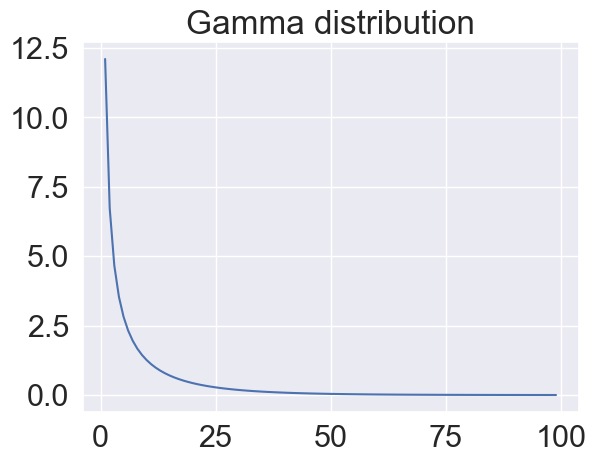

In [8]:
# scale == \theta
# в scipy все распределения определены с точность до смещения и масштаба
x = np.linspace(0, 1, 100)
alpha = 0.23
beta = 5.35

plt.figure()
plt.plot(gamma.pdf(x, scale=1 / beta, a=alpha))
plt.title("Gamma distribution")
plt.show()

In [9]:
np.random.seed(1337)
X = gamma.rvs(scale=1 / beta, a=alpha, size=100)

In [10]:
gamma.pdf(X[0], scale=1 / beta, a=alpha)

119.31210382989336

In [11]:
np.prod(gamma.pdf(X, scale=1 / beta, a=2.5))

1.653645679480908e-267

Уравнение правдоподобия чаще всего записывается с использованием логарифма вероятности, так как в этом случае произведение переходит в сумму, что сильно упрощает жизнь.

$$\mathcal{\log L} = \sum\limits_i \log p(x_i|\theta)$$

  * более хорошая численная стабильность(предотвращает overflow или underflow ошибки);
  * более (относительно)точные градиенты;
  * более гладкая задача(методы оптимизации лучше работают).

Посмотрим на зависимость log-likelihood для нашей задачи с гамма-распределением.

$$\mathcal{L} = \prod\limits_i \frac{\beta^\alpha}{\Gamma(\alpha)} {x_i}^{\alpha-1} \exp(-\beta x_i)$$

$$\mathcal{\log L} = \sum\limits_i \left(  \alpha \log \beta - \log \Gamma(\alpha) - \beta x_i + (\alpha - 1) \log x_i \right)$$

(Обратим внимание насколько простой стала зависимость от $x_i$:)

In [12]:
a = np.linspace(0, 1, 200)
likelihood = np.prod(
    gamma.pdf(
        X[:, np.newaxis], 
        scale=1 / beta, 
        a=a), 
        axis=0
)

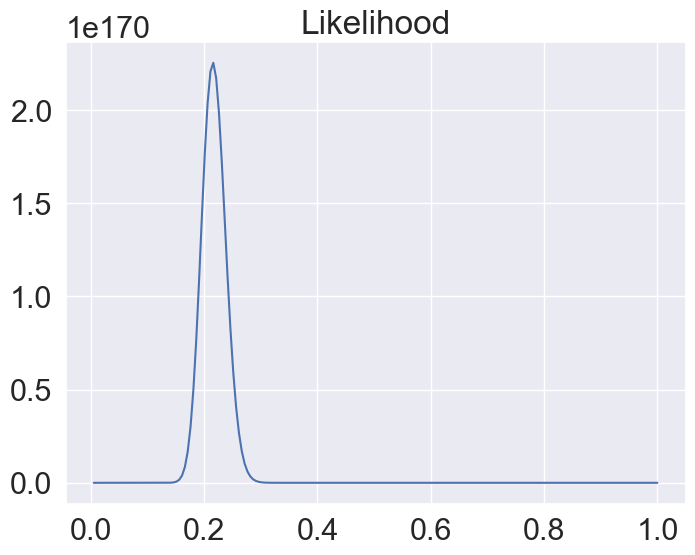

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(a, likelihood)
plt.title('Likelihood')
plt.show()

Text(0.5, 1.0, 'Log-Likelihood')

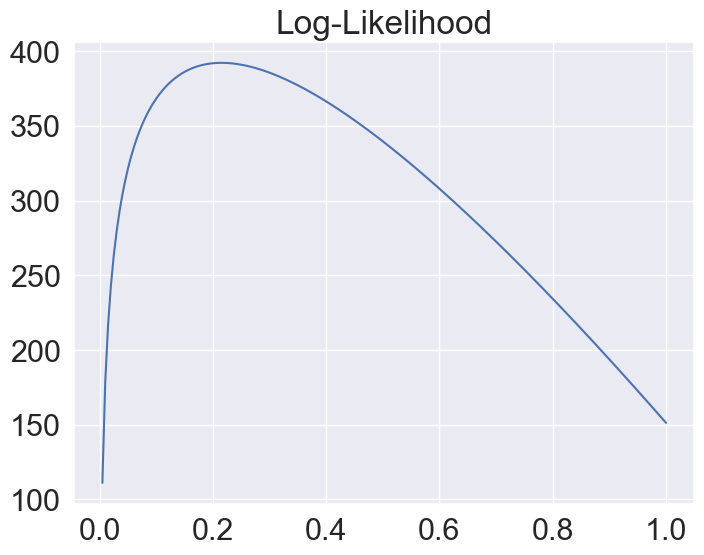

In [14]:
log_likelihood = np.sum(gamma.logpdf(X[:, np.newaxis], 
                        scale=1 / beta, 
                        a=a), 
            axis=0)

plt.figure(figsize=(8, 6))
plt.plot(a, log_likelihood)
plt.title('Log-Likelihood')

### MLE? MLE!

В большинстве задач, если это не игровые примеры, найти явную форму для оценки параметров с помощью MLE очень сложно.

$$\theta^* = \arg \max \log \mathcal{L}(X, \theta)$$

Берём первую производную по каждому параметра распределения и приравниваем к нулю:

$$ \mathcal{\log L}'(X, \theta) = 0$$

Для параметра $\beta$ гамма-распределения:

$$\mathcal{\log L}'_\beta = \sum\limits_{i} \frac{\alpha}{\beta} - x_i = 0$$

$$\beta = \frac{\alpha N}{\sum\limits_i x_i}$$

Для параметра $\alpha$:

$$\mathcal{\log L}'_\alpha = \sum \log \beta + \log x_i - \psi(\alpha) = 0$$

$$\alpha = \log \beta + \frac{1}{N} \sum \log x_i$$


Итого:

$$\alpha = \log \beta + \frac{1}{N} \sum \log x_i$$

$$\beta = \frac{\alpha N}{\sum\limits_i x_i}$$

Увы, точного решения нет. 

На хвала разработчикам open source software!

In [ ]:
gamma.fit?

In [15]:
alpha, _, beta = gamma.fit(X, floc=0.)
beta = 1 / beta
print(alpha, beta)

0.2313491743258105 7.52708487472913


## Пришло время эксперимента :)

In [56]:
%%time
boot = 1000
alphas = []
betas = []
fitted_alphas = []
fitted_betas = []
for i in range(boot):
    X = gamma.rvs(scale=1 / beta, a=alpha, size=1000) # x ~ Gamma(0.23, 7.5)
    fit_alpha, _, fit_beta = gamma.fit(X, floc=0) # fit
    fitted_betas.append(1 / fit_beta) 
    fitted_alphas.append(fit_alpha)

CPU times: user 95.5 ms, sys: 2.98 ms, total: 98.5 ms
Wall time: 98.3 ms


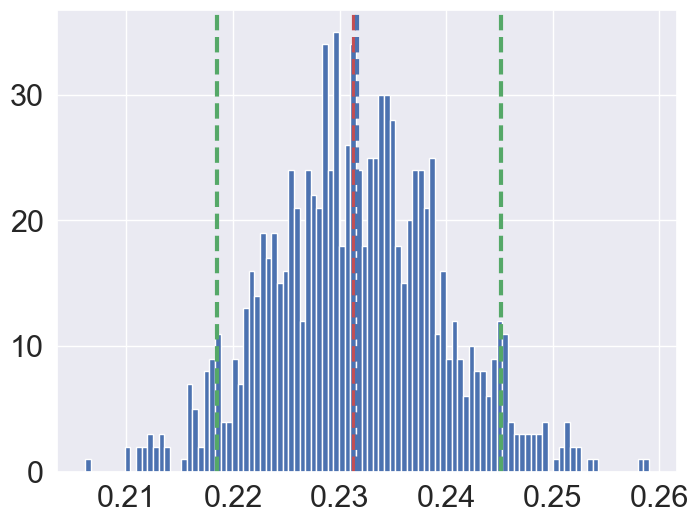

In [57]:
plt.figure(figsize=(8, 6))

plt.hist(fitted_alphas, bins=100);
alpha_q5, alhpa_q95 = np.percentile(fitted_alphas, [5, 95])
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.mean(fitted_alphas), linewidth=3, color='b',linestyle='--')
plt.axvline(x=alpha_q5, linewidth=3, color='g',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='g',linestyle='--')

plt.show()

In [41]:
0.01 / 0.23

0.043478260869565216

In [18]:
np.mean(np.array(fitted_alphas) - alpha)

0.0005185879364810244

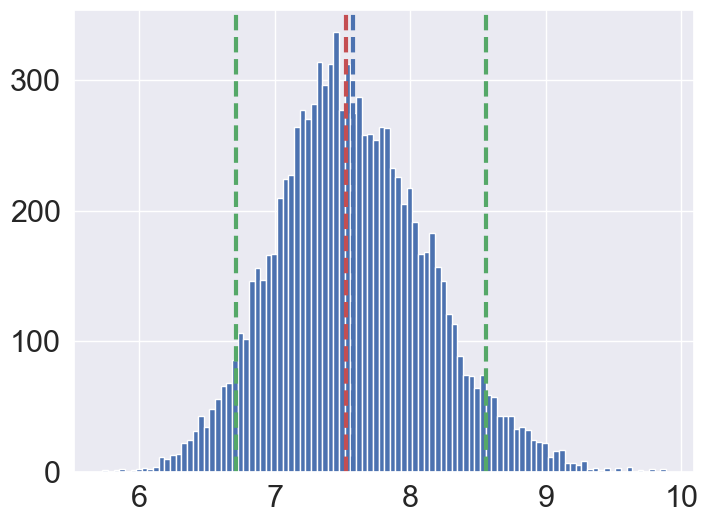

In [19]:
plt.figure(figsize=(8, 6))

plt.hist(fitted_betas, bins=100);
beta_q5, beta_q95 = np.percentile(fitted_betas, [5, 95])
plt.axvline(x=beta, linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.mean(fitted_betas), linewidth=3, color='b',linestyle='--')
plt.axvline(x=beta_q5, linewidth=3, color='g',linestyle='--')
plt.axvline(x=beta_q95, linewidth=3, color='g',linestyle='--')

plt.show()

In [22]:
np.mean(np.array(fitted_betas) - beta)

0.05052406479822088

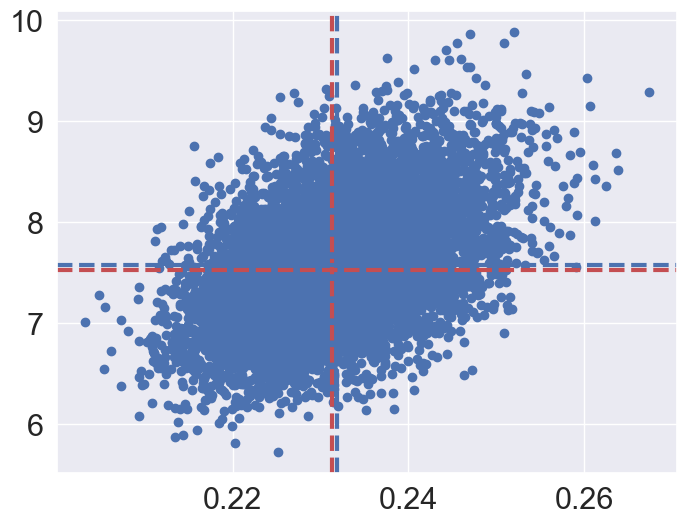

In [23]:
plt.figure(figsize=(8, 6))

plt.scatter(fitted_alphas, fitted_betas)
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.mean(fitted_alphas), linewidth=3, color='b', linestyle='--')
plt.axhline(y=beta, linewidth=3, color='r',linestyle='--')
plt.axhline(y=np.mean(fitted_betas), linewidth=3, color='b', linestyle='--')

plt.show()

In [24]:
np.mean(fitted_alphas)

0.23186776226229153

In [25]:
np.corrcoef(fitted_alphas, fitted_betas)

array([[1.       , 0.4676721],
       [0.4676721, 1.       ]])

In [26]:
from scipy.stats import pearsonr
pearsonr(fitted_alphas, fitted_betas)

PearsonRResult(statistic=0.46767209839172535, pvalue=0.0)

### Оценка смещения

Как мы видим, MLE дал смещённую оценку. Это связано с тем что MLE даёт состоятельную, __асимптотически__ эффективную и __асимптотически__ нормальную оценку.

In [58]:
%%time
boot = 10000
sizes = np.logspace(1, 3, 10).astype(int)

bias_alphas = []
bias_betas = []

for size in sizes:
    fitted_alphas = []
    fitted_betas = []
    for i in range(boot):
        X = gamma.rvs(scale=1 / beta, a=alpha, size=size)
        fit_alpha, _, fit_beta = gamma.fit(X, floc=0)
        fitted_betas.append(1 / fit_beta)
        fitted_alphas.append(fit_alpha)
        
    bias_alphas.append(np.mean(fitted_alphas) - alpha)
    bias_betas.append(np.mean(fitted_betas) - beta)

CPU times: user 4.53 s, sys: 22.1 ms, total: 4.56 s
Wall time: 4.56 s


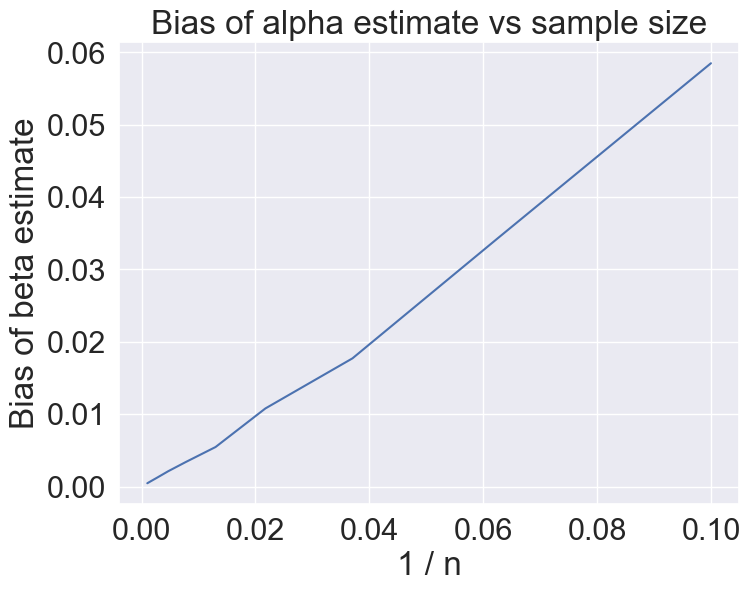

In [59]:
plt.figure(figsize=(8, 6))
plt.title("Bias of alpha estimate vs sample size")
plt.xlabel("1 / n")
plt.ylabel("Bias of beta estimate")
plt.plot(1 / sizes, bias_alphas);


plt.show()

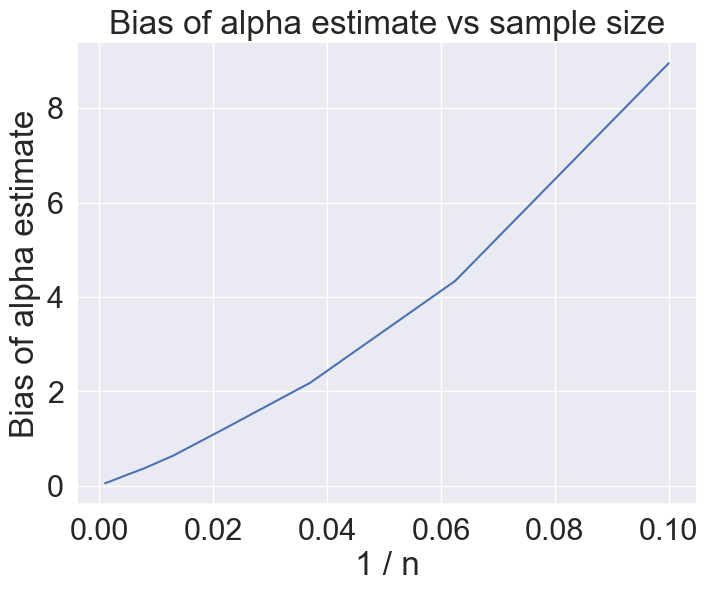

In [60]:
plt.figure(figsize=(8, 6))
plt.title("Bias of alpha estimate vs sample size")
plt.xlabel("1 / n")
plt.ylabel("Bias of alpha estimate")
plt.plot(1 / sizes, bias_betas);

plt.show()

Как мы видим, ???.

### Страшно ли это?

Зависит от контекста, но в целом MLE-оценки являются $\sqrt{n}$-состоятельной, то есть дисперсия оценки уменьшается значительно медленнее чем смещение, поэтому дисперсия практически всегда доминирует над наблюдаемым смещением (сравните ширину гистограммы и положение смещения на графиках выше).

### Что делать если вы всё же хотите избавиться от смещения?

1. Аналитически посчитать смещение: $$\mathrm{bias} = E_{p(X | \theta)} \theta_{MLE} - \theta$$


#### Пример

В качестве примера возьмём равномерное распределение: $x_i \sim U[0, a]$. 

$$\log p(x|a) = - \sum_{x_i}\log {a} = - n \log a$$

$$\frac{d}{d a} \log p(x|a) = -\frac{n}{a}$$

Так как производная монотонная (то есть лайклихуд достигает максимума на границе интервала), то MLE-оценка будет следующая:

$$a_{MLE} = \max_i{x_i}$$

А теперь оценим смещение MLE оценки. Первым делом выпишем функцию распределения максимума:

$$P(\max_i{x_i} < T) = P(x_1 < T)P(x_2 < T)\dots P(x_n < T) = \left( \frac{T}{a} \right)^n$$

Плотность распределения максимума: 

$$p(\max_i{x_i}) = \frac{d}{dT} P(\max_i{x_i} < T) = n \left( \frac{T}{a} \right)^{n-1} \frac{1}{a} $$

Аналитически считаем смещение

$$E_{p(\max_i{x_i}|a)} a_{MLE} = \int n  a_{MLE} \left( \frac{a_{MLE}}{a} \right)^{n-1} \frac{1}{a} da_{MLE} = \frac{n}{n+1} a $$

То есть чтобы пофиксить байес нужно лишь домножить $\frac{n+1}{n} a_{MLE}$.

2. Если аналитически посчитать смещение сложноо, то можно воспользоваться бутстрапом. Если лайклихуд гладкий, то очень хорошо работает jacknife-бутстрап. 

3. Более экзотические методы: коррекция Cox-Snell: 

https://cran.r-project.org/web/packages/ssdtools/vignettes/small-sample-bias.pdf

https://www.jstor.org/stable/2984505

https://journal.r-project.org/archive/2017/RJ-2017-055/RJ-2017-055.pdf

    
(1) требует повышенных ручных вычислений, (2) требует вычислительных более серьёзных мощностей, (3) вычислительно лёгкая и не требует аналитических выкладок, но избавляется только от $(1 / n)$-смещения, для более тонкой коррекции ($1/n^2$ и т.д.) требуется итеративное применение процедуры.

## 2.2 Метод моментов

С гамма-распределением нам повезло что в `scipy` есть метод для фитирования правдоподобия. А если бы его не было?.. Например, если мы сами придумали новое распределение для которого непосредственно оптимизировать лайклихуд очень сложно.

Если мы хотим определить параметры некоторого распределения $p(x | \theta)$, то давайте приравняем моменты данного распределения к моментам подсчитанным по данным($X = \{ x_1, \dots, x_n \}$) и решим уравнения относительно данных моментов.

Моменты по данным считаются следующим образом:

$$\hat{\mu}_k = \frac{1}{n} \sum\limits_{i=1}^{n} x_i^k$$

Моменты распределений:

$$\mu_k = \sum\limits_{i=1}^{n} x^k p(x | \theta) dx$$

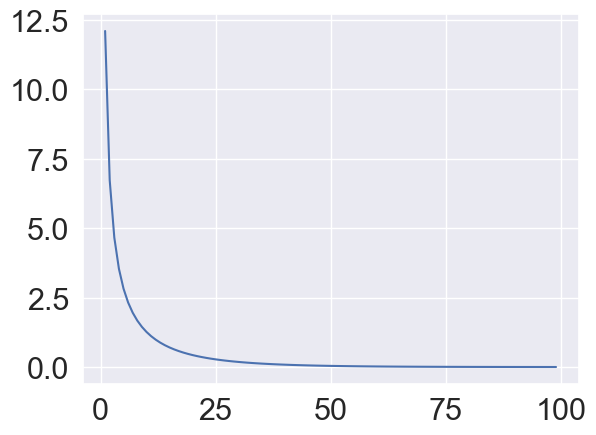

In [61]:
from scipy.stats import gamma
# scale == \theta
# в scipy все распределения определены с точность до смещения и масштаба
x = np.linspace(0, 1, 100)
alpha = 0.23
beta = 5.35
plt.plot(gamma.pdf(x, scale=1 / beta, a=alpha))

Среднее и дисперсия гамма-распределения:

$$\mu(\Gamma) = \frac{\alpha}{\beta}$$

$$Var(\Gamma) = \frac{\alpha}{\beta^2}$$

Применяем метод моментов:

$$\hat{\mu}_1 = \frac{\alpha}{\beta}$$

$$\hat{\mu}_2 = \frac{\alpha^2}{\beta^2} + \frac{\alpha}{\beta^2}$$

Решая систему уравнений получаем:

$$\beta = \frac{\hat{\mu}_1}{\hat{\mu}_2 - \hat{\mu}_1^2}$$

$$\alpha = \hat{\mu}_1 \beta$$

In [62]:
%%time
boot = 10000
fitted_alphas = []
fitted_betas = []
for i in range(boot):
    X = gamma.rvs(scale=1 / beta, a=alpha, size=1000)
    mu_1 = X.mean()
    mu_2 = np.square(X).mean()
    fitted_betas.append(
        mu_1 / (mu_2 - mu_1**2)
    )
    
    fitted_alphas.append(
        mu_1**2 / (mu_2 - mu_1**2)
    )

CPU times: user 573 ms, sys: 2.94 ms, total: 576 ms
Wall time: 575 ms


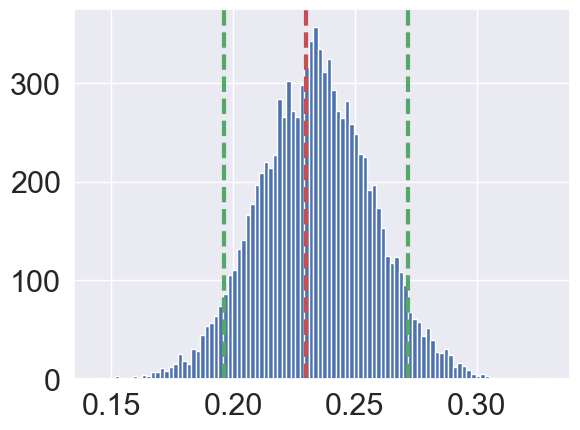

In [63]:
plt.hist(fitted_alphas, bins=100);
alpha_q5, alhpa_q95 = np.percentile(fitted_alphas, [5, 95])
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=alpha_q5, linewidth=3, color='g',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='g',linestyle='--')

In [64]:
np.mean(np.array(fitted_alphas) - alpha)

0.003836089188000316

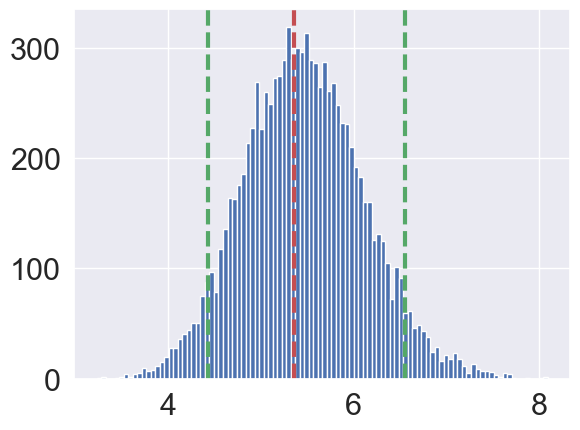

In [65]:
plt.hist(fitted_betas, bins=100);
beta_q5, beta_q95 = np.percentile(fitted_betas, [5, 95])
plt.axvline(x=beta, linewidth=3, color='r',linestyle='--')
plt.axvline(x=beta_q5, linewidth=3, color='g',linestyle='--')
plt.axvline(x=beta_q95, linewidth=3, color='g',linestyle='--')

In [66]:
np.mean(np.array(fitted_betas) - beta)

0.10956133823980872

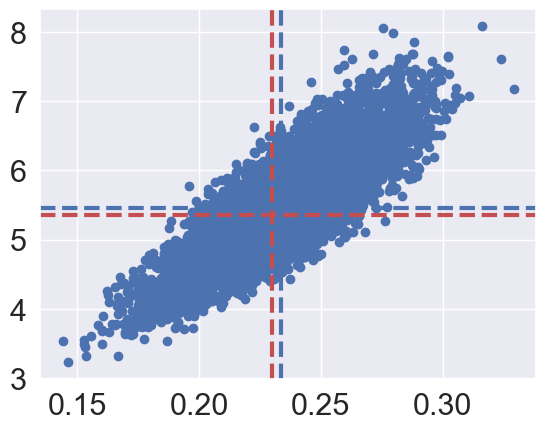

In [67]:
plt.scatter(fitted_alphas, fitted_betas)
plt.axvline(x=alpha, linewidth=3, color='r',linestyle='--')
plt.axvline(x=np.mean(fitted_alphas), linewidth=3, color='b', linestyle='--')
plt.axhline(y=beta, linewidth=3, color='r',linestyle='--')
plt.axhline(y=np.mean(fitted_betas), linewidth=3, color='b', linestyle='--')

In [69]:
from scipy.stats.stats import pearsonr
np.corrcoef(fitted_alphas, fitted_betas)

/var/folders/0w/r6kn96y547sgcsd0_vh68ysm0000gn/T/ipykernel_95557/4010319248.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


array([[1.        , 0.83561357],
       [0.83561357, 1.        ]])

In [70]:
pearsonr(fitted_alphas, fitted_betas)

PearsonRResult(statistic=0.8356135708057685, pvalue=0.0)

### Оценим смещение для метода моментов

In [71]:
%%time
boot = 10000
sizes = np.logspace(1, 3, 10).astype(int)

bias_alphas = []
bias_betas = []

for size in sizes:
    fitted_alphas = []
    fitted_betas = []
    for i in range(boot):
        X = gamma.rvs(scale=1 / beta, a=alpha, size=size)
        mu_1 = X.mean()
        mu_2 = np.square(X).mean()
        fitted_betas.append(
            mu_1 / (mu_2 - mu_1**2)
        )

        fitted_alphas.append(
            mu_1**2 / (mu_2 - mu_1**2)
        )
        
    bias_alphas.append(np.mean(fitted_alphas) - alpha)
    bias_betas.append(np.mean(fitted_betas) - beta)

CPU times: user 2.95 s, sys: 16.5 ms, total: 2.97 s
Wall time: 2.97 s


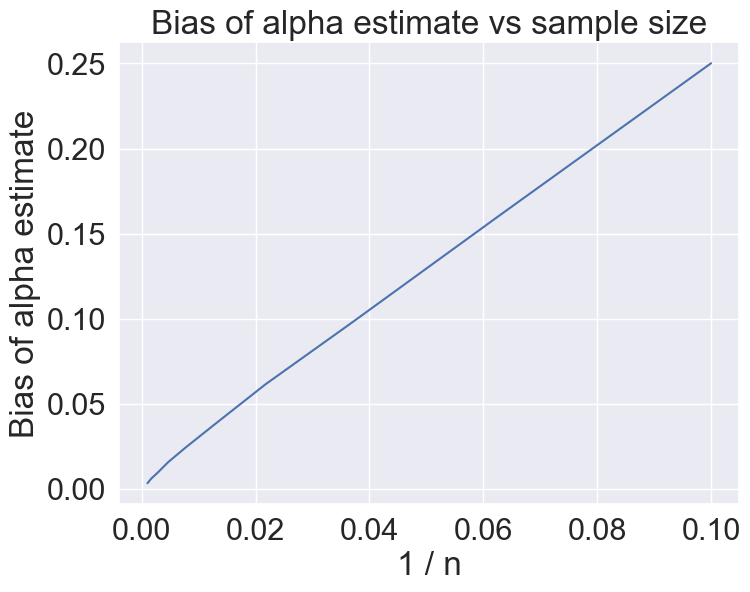

In [72]:
plt.figure(figsize=(8, 6))
plt.title("Bias of alpha estimate vs sample size")
plt.xlabel("1 / n")
plt.ylabel("Bias of alpha estimate")
plt.plot(1 / sizes, bias_alphas);

plt.show()

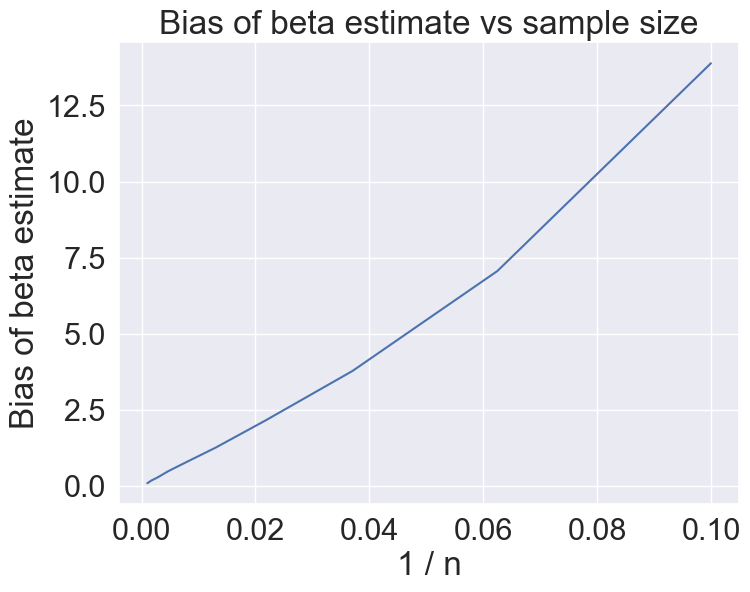

In [73]:
plt.figure(figsize=(8, 6))
plt.title("Bias of beta estimate vs sample size")
plt.xlabel("1 / n")
plt.ylabel("Bias of beta estimate")
plt.plot(1 / sizes, bias_betas);

plt.show()

## Выводы

Что мы можем сказать, сравнив метод моментов и MLE оценки? Как они соотносятся?

Когда использовать MoM?

1. Для быстрых оценок параметров когда MLE не даёт аналитического решения.
2. Для инициализации переменных для более адвансовых методов оптимизации.
3. Для оценки казуальных эффектов (область в развитии):
    1. https://papers.nips.cc/paper/2019/file/15d185eaa7c954e77f5343d941e25fbd-Paper.pdf

# 3. MAP

Предположим, что вы подбросили моменту один раз и у вас выпал орёл. 

Распределение описывается распредлением Бернулли: $p(x=1, q) = q$.

Для выборки $x_1, x_2, \dots, x_N$ правдоподобие записывается следующим образом:

$$p(X| q) = \prod q^{x_i} (1 - q)^{1-x_i}$$

$$\log p(X| q) = \sum\left[ x_i \log q + (1 - x_i) \log(1 - q) \right]$$

Тогда оценка на параметры высчитывается следующим образом:


$$\frac{\partial }{\partial q} \log p(X| q) = \frac{1}{q} \sum x_i - \frac{1}{1-q} \sum (1 - x_i) = 0$$

Получаем:

$$q = \frac{\sum x_i}{n}$$

В согласии с методом максимума правдоподобия следует, что $p=1$, т.е. следует что монетка всегда будет выпадать орлом.

Такая оценка не очень хорошо согласуется с реальностью. 

Однако у вас есть некоторое априорное знание. Вы точно знаете, что честная монетка выпадает орлом в 50% случаев.

Можем ли мы как-то это использовать? Да, это обеспечивается введением априорного распределения.

В MLE параметры оценивались путём максимизации правдоподобия:

$$q = \mathrm{argmax} \log P(X | q) = \mathrm{argmax} \sum \log p(x_i, q) $$


В MAP мы вводим распределение $P(q)$ -- наше априорное знание о распределении параметров. И в MAP мы максимизируем апостериорную вероятность $p(q | X)$:

$$
q = \mathrm{argmax}  P(X | q) P(q) = \mathrm{argmax} \left( \sum  \log p(x_i, q) \right) P(q)
$$

Вернёмся к монете.

В качестве априорного распределения выберем бета-распределение со следующей плотностью:

$$P(q | \alpha, \beta) = \frac{1}{B(\alpha, \beta)} q^{\alpha - 1} (1 - q)^{\beta - 1}$$

![beta](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/531px-Beta_distribution_pdf.svg.png)

В таком случае апостериорная плотность вероятности выглядит следующим образом:

$$p(X, q) p(q) = \prod q^{x_i} (1 - q)^{1-x_i} \frac{1}{B(\alpha, \beta)} q^{\alpha - 1} (1 - q)^{\beta - 1}$$

Лог-вероятность:

$$\log p(X, q) p(q) = (\alpha - 1) \log q + (\beta - 1) \log (1 - q) +  \sum\left[ x_i \log q + (1 - x_i) \log( - q) \right] $$

Прооптимизируем наше выражение путём приравнивания производной к 0:

$$\frac{\partial }{\partial q} \log p(X, q) p(q) = $$

$$ = \frac{1}{q} \sum x_i - \frac{1}{1-q} \sum (1 - x_i) + \frac{\alpha - 1}{q} - \frac{\beta - 1}{1 - q} = 0$$

Решая уравнение выше получаем:

$$\mu = \frac{\sum x_i + \alpha - 1}{n + \beta + \alpha - 2}$$


Пусть наш приор $\alpha=\beta=2$ (см. картинку выше).

Тогда при одном броске монеты получаем следующую оценку:

$$q = \frac{1 + 2 - 1}{1 + 2 + 2 - 2} = \frac{2}{3} \approx 0.66$$


### Какой физический смысл у $\alpha$ и $\beta$?

Вводя прайор $P(q | \alpha, \beta)$ мы добавляем $\alpha - 1$ "виртуальных"бросков монеты орлом и $\beta - 1$ "виртуальных" бросков монеты решкой.

### Проведём небольшой эксперимент с $q = 0.4$ и сравненим  MLE и MAP с разными прайорами

In [ ]:
q = 0.4
coin_flips = np.random.binomial(n=1, p=q, size=500)

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)

a = 18
b = 42
plt.plot((np.cumsum(coin_flips) + a - 1) / (np.cumsum(np.ones_like(coin_flips)) + b + a - 2), label="a={}, b={}".format(a, b))

a = 36
b = 84
plt.plot((np.cumsum(coin_flips) + a - 1) / (np.cumsum(np.ones_like(coin_flips)) + b + a - 2), label="a={}, b={}".format(a, b))

a = 24
b = 36
plt.plot((np.cumsum(coin_flips) + a - 1) / (np.cumsum(np.ones_like(coin_flips)) + b + a - 2), label="a={}, b={}".format(a, b))

a = 48
b = 72
plt.plot((np.cumsum(coin_flips) + a - 1) / (np.cumsum(np.ones_like(coin_flips)) + b + a - 2), label="a={}, b={}".format(a, b))

plt.plot(np.cumsum(coin_flips) / np.cumsum(np.ones_like(coin_flips)), label="MLE")

plt.legend()
plt.show()

### Выводы

    1. В случае большого размера выборки MLE лучше чем плохой прайор.
    2. В случае очень маленького размера выборки (<10) даже плохой прайор лучше чем никакой.
    3. В случае среднего размера выборки нет особой разницы между MLE и плохим прайором.
    4. Во всех случаях хороший прайор лучше всех (но как его найти?..).

## Разница (одна из) между байесовским подходом и частотным

Для байесовского анализа предположим что прайор у нас плоский, т.е. $p(q) = 1$

А теперь давайте сделаем замену координат!

$$q = t^2$$

Что тогда поменяется?

### MLE

$$p(X | q) = \prod q^{x_i} (1 - q)^{1-x_i} \Rightarrow p(X, t) = \prod (t^2)^{x_i} (1 - t^2)^{1-x_i}$$


Ничего не меняется.

### MAP


$$p(X | q) = \prod q^{x_i} (1 - q)^{1-x_i} \Rightarrow p(X, t) = \prod (t^2)^{x_i} (1 - t^2)^{1-x_i}$$

$$p(q) = 1 \Rightarrow p(t) = 1$$

Тоже ничего не меняется?! Что я сделал не так?


### Что же я сделал не так?

В MLE мы максимизируем $p(X|q)$, а $p(X|q)$ это функция от $q$, поэтому замену $q = t^2$ можно сделать без задней мысли и верно следующее:

$$q_{MLE} = (t_{MLE})^2$$



В MAP мы максимизируем $p(X|q) p(q)$ и вот теперь возникает тонкость!

В $p(X|q)$ замену можно сделать без задней мысли опять: $p(X|q) = p(X|t^2)$.

Но в $p(q)$ сделать замену напрямую нельзя, потому что $p(q)$ это плотность вероятности, которая __не несёт физического смысла__. Физический смысл есть у вероятности: $p(q) dq = P(q' \in [q, q+dq])$ и данная вероятность должна быть __инвариантна__ к замене переменных, т.е.

$$p(q) dq = p(t^2) dt$$

Из чего следует что:

$$p(q) = p(t^2) \frac{dt}{dq}$$

### Дававайте проиллюстрируем это на примере

In [ ]:
q = np.linspace(0, 1, 1000)

prior = lambda x: np.ones_like(x) # flat prior
transformation = lambda x: x**2 # q = t^2
transformation_derivative = lambda x: 2 * x # dq / dt
transformation_inverse = lambda x: np.sqrt(x) # t = sqrt(q)

"""
transformation = lambda x: np.sin(x)
transformation_derivative = lambda x: np.cos(x)
transformation_inverse = lambda x: np.arcsin(x)

transformation = lambda x: x**3
transformation_derivative = lambda x: 3 * x**2
transformation_inverse = lambda x: np.power(x, 1/3)

transformation = lambda x: np.exp(x)
transformation_derivative = lambda x: np.exp(x)
transformation_inverse = lambda x: np.log(x)
"""

t = transformation_inverse(q)

In [ ]:
plt.figure(figsize=(12, 8));

plt.plot(q, t, label="q=t^2", color="b")
plt.plot(q, prior(q), label="p(q)", color="m")
plt.plot(- prior(q) * transformation_derivative(t), t, label="p(t)", color="g")

plt.xlabel("q")
plt.ylabel("t")

q_segment = np.linspace(0.01, 0.2, 20)

plt.fill_between(q_segment, prior(q_segment), alpha=0.3, color="m")
plt.fill_betweenx(transformation_inverse(q_segment), -transformation_derivative(transformation_inverse(q_segment)), alpha=0.3, color='green')


plt.plot(
    [0, q_segment[0]], 
    [transformation_inverse(q_segment[0]), transformation_inverse(q_segment[0])], 
    color="k", linestyle='--'
)
plt.plot(
    [0, q_segment[-1]], 
    [transformation_inverse(q_segment[-1]), transformation_inverse(q_segment[-1])], 
    color="k", linestyle='--'
)

plt.plot(
    [q_segment[0], q_segment[0]], 
    [prior(q_segment[0]), transformation_inverse(q_segment[0])], 
    color="k", linestyle='--'
)
plt.plot(
    [q_segment[-1], q_segment[-1]], 
    [prior(q_segment[-1]), transformation_inverse(q_segment[-1])], 
    color="k", linestyle='--'
)

plt.axvline(0, linewidth=1, color='k', alpha=1)
plt.axhline(0, linewidth=1, color='k', alpha=1)

xticts = plt.xticks()[0]
plt.xticks(xticts, np.abs(xticts))
plt.legend()
plt.show()

## Вывод

    1. MLE инвариантно к замене переменных, то есть вне зависимости от параметризации ответ будет одинаковым
    2. MAP не инвариантно к замене переменных, то есть параметризация будет существенно влиять на результаты